In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import datasets

## Data Generation

In [2]:
diabetes = datasets.load_diabetes()

diabetes_X = diabetes.data[:, np.newaxis, 2]

diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

## Linear regression (gradient descent with locally optimal step size)

In [3]:
def h(X, theta):
    return theta[0] + np.dot(theta[1:],X.T)

### Cost function

In [4]:
def function(X, y, theta):
    cost = sum(h(X,theta) - y)**2
    return cost/len(X)

### Gradient

In [5]:
def Gradient(features, predictions, theta):
    grad = []
    for val in range(len(theta)):
        if val == 0:
            grad.append(1/2/len(features) * sum((h(features,theta) - predictions)))
        else:
            grad.append(1/2/len(features) * sum(features[val]*(h(features,theta) - predictions)))
    return grad

In [6]:
def next_value(current_value, Lambda, gradient):
    '''determines value for a one-dimensional step search'''
    
    next_value_Lambda = [current_value[i]- Lambda*gradient[i] for i in range(len(gradient))]
    return next_value_Lambda

### Swenn method

In [7]:
def Swenn_method(L_initial, delta_L, features, predictions, x, gradient):
    '''determines line-segment for the optimal step'''
    
    L_next = 0
    step = 0
    
    past_function_value = function(features, predictions, next_value(x, L_initial, gradient))
    left_shift = function(features, predictions, next_value(x, (L_initial - abs(delta_L)), gradient))
    right_shift = function(features, predictions, next_value(x, (L_initial + abs(delta_L)), gradient))
    
    if left_shift >= past_function_value >= right_shift:
        sign = 1
        
    elif left_shift <= past_function_value <= right_shift:
        sign = -1
        
    else:
        return [L_initial - abs(delta_L),L_initial + abs(delta_L)]
        
    while step <= 1000:
        fake_new_step = L_initial + sign*pow(2,step)*delta_L
        current_position = function(features, predictions, next_value(x, fake_new_step, gradient))
        if current_position >= past_function_value:
            new_step = (L_initial + fake_new_step)/2
            initial_position = function(features, predictions, next_value(x, L_initial, gradient))
            condL = function(features, predictions, next_value(x, new_step, gradient))
            if initial_position <= condL <= current_position:
                return [min(L_next, new_step), max(L_next, new_step)]
            elif initial_position >= condL <= current_position:
                return [L_initial, fake_new_step]
        else:
            past_function_value = current_position
            L_next = L_initial
            L_initial = fake_new_step
            step = step + 1

### Golden-section search

In [8]:
def Golden_ratio_method(interval,accuracy, features,predictions, step, gradient):
    '''determines optimal step for every iteration'''
    
    length = max(interval) - min(interval)
    Lambda_left = min(interval) + 0.382*length
    Lambda_right = min(interval) + 0.618*length
    
    while (length >= accuracy):
        cond_left = function(features,predictions, next_value(step, Lambda_left, gradient))
        cond_right = function(features,predictions, next_value(step, Lambda_right, gradient))
        if cond_left <= cond_right:
            length = Lambda_right - min(interval)
            Lambda_right = Lambda_left
            Lambda_left = min(interval) + 0.382*length
            interval = [min(interval), Lambda_right]
        elif cond_left >= cond_right:
            length = max(interval) - Lambda_left
            Lambda_left = Lambda_right
            Lambda_right = Lambda_left + 0.618*length
            interval = [Lambda_left, max(interval)]
            mean = (max(interval) + min(interval))/2
            return(mean)

### Gradient descent

In [9]:
def linear_regression_gradient_descent(accuracy, features, predictions, theta):
    
    theta = np.array(theta)    
    alpha = 0.3
    grad = Gradient(features,predictions, theta)
    

    while pow(((grad[0] ** 2)+(grad[1] ** 2)),0.5) >= accuracy:
        interval = Swenn_method(alpha, 0.05, features,predictions, theta, grad)
        alpha = Golden_ratio_method(interval, 0.05, features,predictions, theta, grad)
        new_theta = []
        for val in range(len(grad)):
            new_theta.append(theta[val] - alpha*grad[val])
        theta = np.array(new_theta)
        grad = Gradient(features,predictions, theta)
    
    return theta

In [10]:
regr_coeficients = linear_regression_gradient_descent(0.01, diabetes_X_train, diabetes_y_train, [1,900])

In [11]:
regr_coeficients

array([ 152.94052108,  892.17900431])

In [12]:
X_test = np.concatenate((np.ones(len(diabetes_X_test)).reshape(len(diabetes_X_test),1), diabetes_X_test), axis=1)

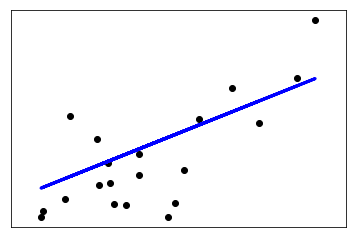

In [13]:
y_pred = np.dot(regr_coeficients, X_test.T)

plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

Linear regression (Ordinary Least Squares)

In [14]:
def linear_regression_ols(X_train, y_train, X_test):
    X = np.concatenate((np.ones(len(X_train)).reshape(len(X_train),1), X_train), axis=1)
    regr_coef = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y_train))
    y_pred = [regr_coef[0] + sum([regr_coef[j] * X_test[i, j-1] for j in range(1,len(regr_coef))]) for i in range(len(X_test))]
    return y_pred

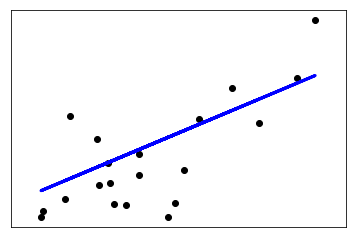

In [15]:
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
y_pred = linear_regression_ols(diabetes_X_train, diabetes_y_train, diabetes_X_test)
plt.plot(diabetes_X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

Linear regression (sklearn)

In [16]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [17]:
regr = linear_model.LinearRegression()

regr.fit(diabetes_X_train, diabetes_y_train)

diabetes_y_pred = regr.predict(diabetes_X_test)

print('Coefficients: \n', regr.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

Coefficients: 
 [ 938.23786125]
Mean squared error: 2548.07
Variance score: 0.47


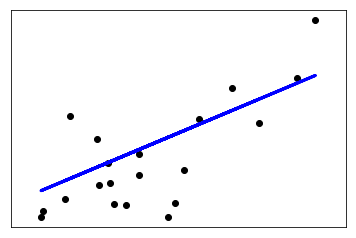

In [18]:
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()